# Лабораторная работа 1

1) Классификация данных методом k ближайших соседей ( kNN)

3) Построение softmax-классификатора

Вариант 4: задания 1 и 3 на наборе данных MNIST

Лабораторные работы можно выполнять с использованием сервиса Google Colaboratory (https://medium.com/deep-learning-turkey/google-colab-free-gpu-tutorial-e113627b9f5d) или на локальном компьютере. 

## 1. Классификация данных методом k ближайших соседей ( kNN)

In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) 
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

1.1 Скачайте данные в соответсвии с заданием.

CIFAR-10 по ссылке https://www.cs.toronto.edu/~kriz/cifar.html
или используйте  команду !bash get_datasets.sh (google colab, local ubuntu)

MNIST 
sklearn.datasets import load_digits
digits = load_digits()

In [2]:
from sklearn.datasets import load_digits

X, y = load_digits(return_X_y = True)

1.2 Выведите несколько примеров изображений из обучающей выборки для каждого класса.



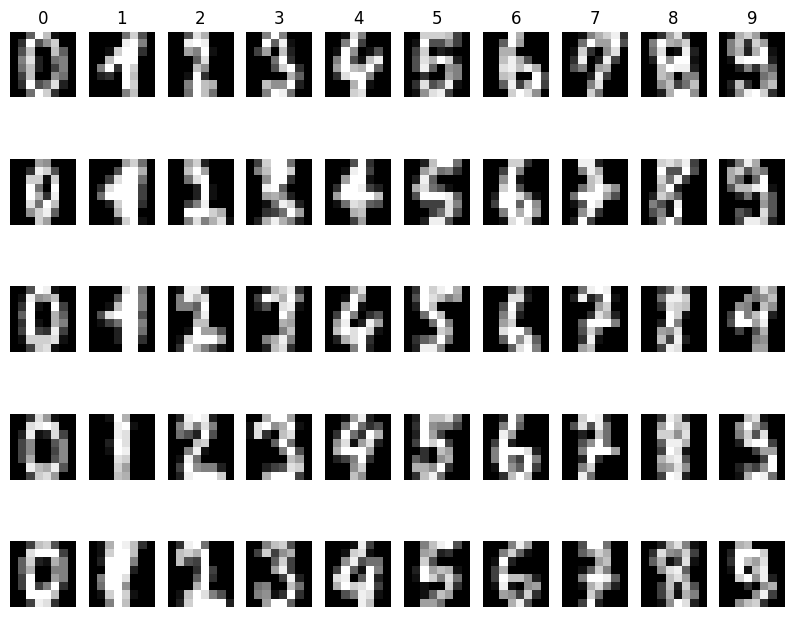

In [3]:
n_classes = np.unique(y).shape[0]
n_samples = 5

for class_index in np.unique(y):
    class_indices = np.random.choice(np.flatnonzero(y == class_index), n_samples, replace=False)
    for i, idx in enumerate(class_indices):
        plt_idx = i * n_classes + class_index + 1
        plt.subplot(n_samples, n_classes, plt_idx)
        plt.imshow(X[idx].reshape(8,8).astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(class_index)
plt.show()

1.3 Разделите данные на обучающу и тестовую выборки (X_train, y_train, X_test, y_test). Преобразуйте каждое изображение в одномерный массив. 

In [4]:
from sklearn.model_selection import train_test_split
from time import time

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
print('training data shape: ', X_train.shape)
print('training labels shape: ', y_train.shape)
print('test data shape: ', X_test.shape)
print('test labels shape: ', y_test.shape)

training data shape:  (1437, 64)
training labels shape:  (1437,)
test data shape:  (360, 64)
test labels shape:  (360,)


Датасет MNIST по умолчанию предоставляет изображения в виде одномерного массива.

1.4 Напишите реализацию классификатора в скрипте /classifiers/k_nearest_neighbor.py и обучите его на сформированной выборке. 

In [5]:
from scripts.classifiers import KNearestNeighbor

classifier = KNearestNeighbor()
classifier.train(X_train, y_train)

1.5 Выполните классификацию на тестовой выборке

In [6]:
knn_dists = classifier.compute_distances_two_loops(X_test)

1.6 Визуализируйте матрицу расстояний для каждого изображения из тестовой выборки до изображений из обучающей выборки. 


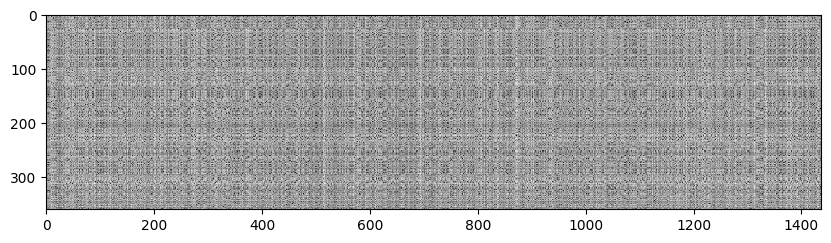

In [7]:
plt.imshow(knn_dists, interpolation='none')
plt.show()


1.7 Посчитайте долю правильно классифицированных изображений из тестовой выборки.


In [8]:
from sklearn.metrics import accuracy_score

y_pred = classifier.predict_labels(knn_dists)
print("accuracy: " + str(accuracy_score(y_test, y_pred)))

accuracy: 0.9777777777777777


1.8 Постройте график зависимости доли правильно классифицированных изображений от числа соседей, используемых при классификации.

In [9]:
k_list = range(1, 21)
accuracy_list = [accuracy_score(y_test, classifier.predict(X_test, k=k, num_loops=2)) for k in k_list]

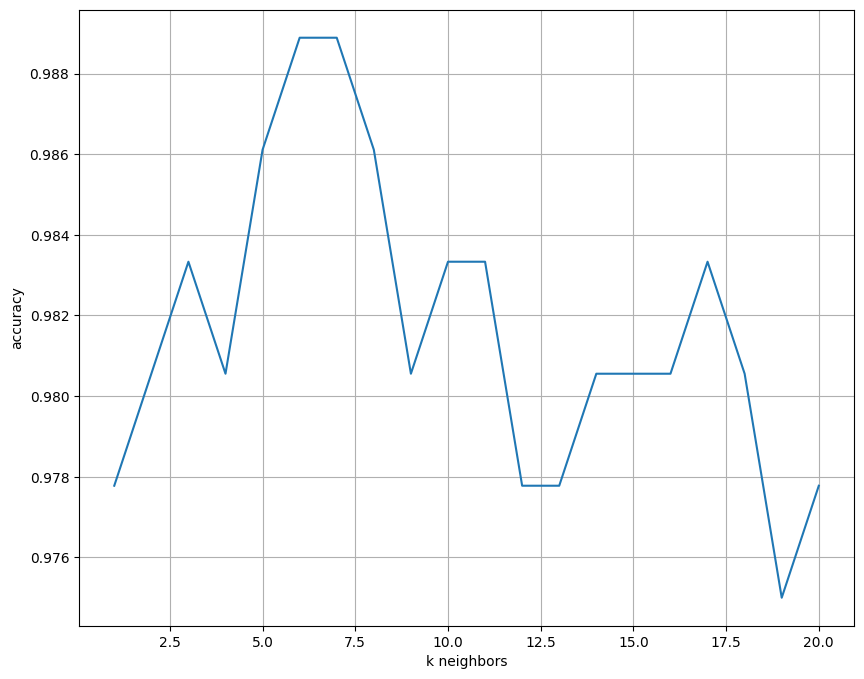

In [10]:
plt.plot(k_list, accuracy_list)
plt.xlabel("k neighbors")
plt.ylabel("accuracy")
plt.grid()
plt.show()

1.9 Выберите лучшее значение параметра k на основе кросс-валидации.


In [11]:
def cv_score(estimator, X, y, k_folds = 5, scoring = accuracy_score, 
             estimator_params = None, train_estimator_params = None, prediction_estimator_params = None, verbose = 1):
    y_folds = np.array_split(y, k_folds)
    X_folds = np.array_split(X, k_folds)

    accuracies = np.zeros((len(y_folds),))

    if verbose > 1:
        print(40 * "=")
        print(f"cross validation for {estimator.__name__}")
        print(40 * "=")
    for fold in range(len(y_folds)):
        if verbose > 1:
            print(40 * "=")
            print(f"fold: {fold}")

        y_train_fold = y_folds
        X_train_fold = X_folds

        y_test_fold = y_train_fold[fold]
        X_test_fold = X_train_fold[fold]

        X_train_elements = []
        y_train_elements = []

        for i, element in enumerate(zip(X_folds, y_folds)):
            if i != fold:
                X_train_elements.append(element[0])
                y_train_elements.append(element[1])

        y_train_fold = np.hstack(y_train_elements)
        X_train_fold = np.vstack(X_train_elements)

        if estimator_params:
            estimator_ = estimator(**estimator_params)
        else:
            estimator_ = estimator()

        if train_estimator_params:
            estimator_.train(X_train_fold, y_train_fold, **train_estimator_params)
        else:
            estimator_.train(X_train_fold, y_train_fold)

        if prediction_estimator_params:
            fold_y_pred = estimator_.predict(X_test_fold, **prediction_estimator_params)
        else:
            fold_y_pred = estimator_.predict(X_test_fold)

        if verbose > 1:
            print(f"score: {scoring(y_test_fold, fold_y_pred)}")
            print(40 * "=")
        accuracies[fold] = scoring(y_test_fold, fold_y_pred)

    return accuracies

In [12]:
import pandas as pd
from sklearn.model_selection import cross_val_score
from scripts.classifiers import KNearestNeighbor

k_possible = [1, 2, 3, 4, 5, 10, 20, 50, 75, 100]
cross_val_results = []

for k in k_possible:
    score = cv_score(KNearestNeighbor, X_train, y_train, prediction_estimator_params={'k':k})
    cross_val_results.append({
        "k": k,
        "score": np.round(score, 3),
    })
    
cross_val_df = pd.DataFrame(data=cross_val_results)
cross_val_df["mean"] = cross_val_df["score"].apply(lambda x: np.mean(x))
cross_val_df["std"] = cross_val_df["score"].apply(lambda x: np.std(x))
cross_val_df

,k,score,mean,std
0,1,"[0.99, 0.983, 0.983, 0.993, 0.983]",0.9864,0.004271
1,2,"[0.993, 0.972, 0.969, 0.99, 0.969]",0.9786,0.010632
2,3,"[0.997, 0.976, 0.972, 0.997, 0.983]",0.9850,0.010412
3,4,"[0.997, 0.983, 0.972, 0.993, 0.972]",0.9834,0.010365
4,5,"[0.997, 0.979, 0.976, 0.99, 0.972]",0.9828,0.009282
5,10,"[0.983, 0.969, 0.972, 0.986, 0.965]",0.9750,0.008124
6,20,"[0.969, 0.944, 0.958, 0.976, 0.958]",0.9610,0.010918
7,50,"[0.92, 0.931, 0.944, 0.948, 0.934]",0.9354,0.009912
8,75,"[0.906, 0.913, 0.93, 0.927, 0.913]",0.9178,0.009152
9,100,"[0.885, 0.903, 0.916, 0.902, 0.882]",0.8976,0.012563


In [13]:
best_k = cross_val_df.sort_values(by="mean").sort_values(by="std", ascending=False).iloc[0]['k']
best_k

100


1.10 Переобучите и протестируйте классификатор с использованием выбранного значения k.



In [14]:
classifier = KNearestNeighbor()
classifier.train(X_train, y_train)
for i in range(3):
    print(f"num loops: {i}, accuracy = {accuracy_score(y_test, classifier.predict(X_test, k=best_k, num_loops=i))}")

num loops: 0, accuracy = 0.9166666666666666
num loops: 1, accuracy = 0.9166666666666666
num loops: 2, accuracy = 0.9166666666666666


1.11 Сделайте выводы по результатам 1 части задания.

1. Метод k-ближайших соседей показывает высокую точность для выбранного набора данных.
2. Точность метода k-ближайших соседей зависит от выбора k. Чем больше k, тем точнее будет модель. Если взять слишком большое k, то модель переобучится и точность уменьшится.

## 3.  Построение softmax-классификатора

3.1 Разделите данные на обучающую, тестовую и валидационную выборки. Преобразуйте каждое изображение в одномерный массив. Выведите размеры выборок.

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = int(time()))
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.2, random_state = int(time()))
print('training data shape: ', X_train.shape)
print('training labels shape: ', y_train.shape)
print('validation data shape: ', X_val.shape)
print('validation labels shape: ', y_val.shape)
print('test data shape: ', X_test.shape)
print('test labels shape: ', y_test.shape)

training data shape:  (1149, 64)
training labels shape:  (1149,)
validation data shape:  (288, 64)
validation labels shape:  (288,)
test data shape:  (360, 64)
test labels shape:  (360,)


3.2 Проведите предварительную обработку данных, путем вычитания среднего изображения, рассчитанного  по обучающей выборке.

3.3 Чтобы далее не учитывать смещение (свободный член b), добавьте дополнитульную размерность к массиву данных и заполните ее единицами.

[0.00000000e+00 3.17667537e-01 5.28894691e+00 1.17658834e+01
 1.17606614e+01 5.77806789e+00 1.23411662e+00 9.05134900e-02
 3.48128808e-03 1.97824195e+00]


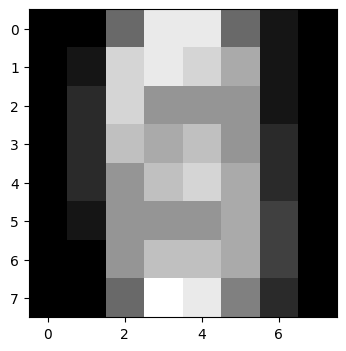

(1149, 65) (288, 65) (360, 65)


In [16]:
mean_image = np.mean(X_train, axis=0)
print(mean_image[:10]) 
plt.figure(figsize=(4,4))
plt.imshow(mean_image.reshape((8,8)).astype('uint8')) 
plt.show()

X_train -= mean_image
X_val -= mean_image
X_test -= mean_image

X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])

print(X_train.shape, X_val.shape, X_test.shape)

3.4 Реализуйте функции в classifiers/softmax.py




In [17]:
from scripts.classifiers.softmax import softmax_loss_naive
import time

# Generate a random softmax weight matrix and use it to compute the loss.
W = np.random.randn(65, 10) * 0.0001
loss, grad = softmax_loss_naive(W, X_train, y_train, 0.0)

# As a rough sanity check, our loss should be something close to -log(0.1).
print('loss: %f' % loss)
print('sanity check: %f' % (-np.log(0.1)))

loss: 2.302571
sanity check: 2.302585


3.5 Убедитесь, что вы верно реализовали расчет градиента, сравнив с реализацией численными методами (код приведен ниже).

In [18]:
loss, grad = softmax_loss_naive(W, X_train, y_train, 0.0)


from scripts.gradient_check import grad_check_sparse
f = lambda w: softmax_loss_naive(w, X_train, y_train, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)


loss, grad = softmax_loss_naive(W, X_train, y_train, 5e1)
f = lambda w: softmax_loss_naive(w, X_train, y_train, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

numerical: 0.600793 analytic: 0.600793, relative error: 2.318566e-10
numerical: 0.013907 analytic: 0.013907, relative error: 1.782116e-09
numerical: -0.170958 analytic: -0.170958, relative error: 1.330960e-10
numerical: -0.252408 analytic: -0.252408, relative error: 2.105897e-10
numerical: 0.129528 analytic: 0.129528, relative error: 2.892636e-11
numerical: -0.277157 analytic: -0.277157, relative error: 1.922447e-10
numerical: 0.019777 analytic: 0.019777, relative error: 3.572674e-09
numerical: -0.463096 analytic: -0.463096, relative error: 1.330305e-10
numerical: 0.123815 analytic: 0.123815, relative error: 1.574632e-10
numerical: 0.478990 analytic: 0.478990, relative error: 6.779471e-11
numerical: -0.128757 analytic: -0.128757, relative error: 5.128369e-10
numerical: -0.005647 analytic: -0.005647, relative error: 9.357788e-10
numerical: 0.140166 analytic: 0.140166, relative error: 3.561443e-10
numerical: -0.413446 analytic: -0.413446, relative error: 7.135260e-11
numerical: -0.187088

3.6 Сравните softmax_loss_naive и softmax_loss_vectorized реализации

In [19]:
tic = time.time()
loss_naive, grad_naive = softmax_loss_naive(W, X_train, y_train, 0.000005)
toc = time.time()
print('naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from scripts.classifiers.softmax import softmax_loss_vectorized
tic = time.time()
loss_vectorized, grad_vectorized = softmax_loss_vectorized(W, X_train, y_train, 0.000005)
toc = time.time()
print('vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))


grad_difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('loss difference: %f' % np.abs(loss_naive - loss_vectorized))
print('gradient difference: %f' % grad_difference)

naive loss: 2.302571e+00 computed in 0.062031s
vectorized loss: 2.302571e+00 computed in 0.001970s
loss difference: 0.000000
gradient difference: 0.000000


3.7 Реализуйте стохастический градиентный спуск в /classifiers/linear_classifier.py . Реализуйте методы train() и predict() и запустите следующий код

3.8 Обучите Softmax-классификатор и оцените accuracy на тестовой выборке.

In [20]:
from scripts.classifiers.linear_classifier import Softmax

softmax_classifier = Softmax()
softmax_classifier.train(X_train, y_train)
print(f"accuracy: {accuracy_score(y_test, softmax_classifier.predict(X_test))}")

accuracy: 0.9111111111111111


3.9 С помощью кросс-валидации выберите значения параметров скорости обучения и регуляризации. В кросс-валидации используйте обучающую и валидационную выборки. Оцените accuracy на тестовой выборке.

In [21]:
learning_rates = [1e-7, 5e-5]
regularization_strengths = [2.5e4, 5e4]

data = []
for learning_rate in learning_rates:
    for regularization_strength in regularization_strengths:
        score = cv_score(
            Softmax,
            X_train,
            y_train,
            train_estimator_params=dict(learning_rate=learning_rate, reg=regularization_strength),
        )
        data.append({
            "learning_rate": learning_rate,
            "regularization_strength": regularization_strength,
            "score": score,
            "mean": np.mean(score),
            "std": np.std(score),
        })

D:\_files\projects\temp\dl-2022\scripts\classifiers\softmax.py:84: RuntimeWarning: overflow encountered in exp
  sum_j = np.sum(np.exp(scores), axis=1).reshape((num_train, 1))
D:\_files\projects\temp\dl-2022\scripts\classifiers\softmax.py:91: RuntimeWarning: overflow encountered in exp
  dW = X.T.dot(np.exp(scores) / sum_j) - X.T.dot(correct_matrix)
D:\_files\projects\temp\dl-2022\scripts\classifiers\softmax.py:91: RuntimeWarning: invalid value encountered in divide
  dW = X.T.dot(np.exp(scores) / sum_j) - X.T.dot(correct_matrix)
D:\_files\projects\temp\dl-2022\scripts\classifiers\softmax.py:84: RuntimeWarning: overflow encountered in exp
  sum_j = np.sum(np.exp(scores), axis=1).reshape((num_train, 1))
D:\_files\projects\temp\dl-2022\scripts\classifiers\softmax.py:91: RuntimeWarning: overflow encountered in exp
  dW = X.T.dot(np.exp(scores) / sum_j) - X.T.dot(correct_matrix)
D:\_files\projects\temp\dl-2022\scripts\classifiers\softmax.py:91: RuntimeWarning: invalid value encountered in 

In [22]:
softmax_cross_val_scores_df = pd.DataFrame(data=data)
softmax_cross_val_scores_df.sort_values(by="mean").sort_values(by="std", ascending=False)

,learning_rate,regularization_strength,score,mean,std
0,1.000000e-07,25000.0,"[0.05652173913043478, 0.15217391304347827, 0.1...",0.109679,0.056691
2,5.000000e-05,25000.0,"[0.8304347826086956, 0.7913043478260869, 0.756...",0.791965,0.030516
1,1.000000e-07,50000.0,"[0.08260869565217391, 0.05217391304347826, 0.0...",0.061807,0.017543
3,5.000000e-05,50000.0,"[0.11304347826086956, 0.10434782608695652, 0.1...",0.100065,0.013627


In [23]:
best_softmax_classifier = Softmax()
best_softmax_classifier.train(X_train, y_train, learning_rate=5e-5, reg=2.5e4)
print(f"accuracy: {accuracy_score(y_test, best_softmax_classifier.predict(X_test))}")

accuracy: 0.7333333333333333


3.10 Сделайте выводы по третьей части задания

На наборе данных MNIST классификатор kNN показывает более высокую точность, чем Softmax.